In [58]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

n_inputs = n_outputs = 3
n_hidden = 2
learning_rate = 0.01

with tf.Graph().as_default():
    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    hidden = fully_connected(X, n_hidden, activation_fn=None)
    outputs = fully_connected(hidden, n_outputs, activation_fn=None)

    error = tf.square(outputs - X)
    reconstruction_loss = tf.reduce_mean(error)

    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(reconstruction_loss)

    with tf.Session() as sess:
        n_iterations = 1000    
        X_train = [
            [1, 2, 3],
            [2, 4, 6]
        ]
        sess.run(tf.global_variables_initializer())
        for iteration in range(n_iterations):
            xx, ouputs_val = sess.run([training_op, outputs], feed_dict={X: X_train})
            if iteration%200==0:
                print(ouputs_val)
        output_val = outputs.eval(feed_dict={X: [[4, 8, 12]]})

print(output_val)

[[-0.45825016  2.82441998 -1.12732375]
 [-0.91650033  5.64883995 -2.25464749]]
[[ 1.13355064  1.95907474  3.20387125]
 [ 1.92831576  4.02181721  5.89067936]]
[[ 1.106529    1.96943009  3.10343981]
 [ 1.94436979  4.01567841  5.94525337]]
[[ 1.06652546  1.98155653  3.04392362]
 [ 1.96564746  4.00925779  5.97699547]]
[[ 1.03292     1.99094868  3.01680088]
 [ 1.98309004  4.00449371  5.99126673]]
[[  3.95334125   8.01264286  11.97905064]]


---

---



## TensorFlow Implementation

mnist에 오토인코딩을 적용해 봅시다. 평범한 다변수 딥러닝을 구축하는 것과 비슷합니다.

minst는 [28 by 28] 형태의 데이타로 한개의 인스턴스는 784차원으로 이루어집니다.

Codings까지 포함해 3개의 hidden 레이어를 사용해 봅시다. 아래 그림과 같은 구조입니다.

![](1.png)

###### (He 초기화, ELU 활성함수, l2 정규화) <= 이게 무슨뜻인가요?

지금은 일단 학습하는 코드만 짜봅니다! 학습에 대한 테스트는 뒤에서 설명합니다.

In [79]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import time

n_inputs = n_outputs = 28 * 28
n_hidden1 = n_hidden3 = 300
n_hidden2 = 150
learning_rate = 0.01
l2_reg = 0.001

with tf.Graph().as_default():
    
    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    with tf.contrib.framework.arg_scope(
        [fully_connected],
        activation_fn=tf.nn.elu,
        weights_initializer=tf.contrib.layers.variance_scaling_initializer(),
        weights_regularizer=tf.contrib.layers.l2_regularizer(l2_reg)
    ):
        hidden1 = fully_connected(X, n_hidden1)
        hidden2 = fully_connected(hidden1, n_hidden2)
        hidden3 = fully_connected(hidden2, n_hidden3)
        outputs = fully_connected(hidden3, n_outputs, activation_fn=None)
        
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([reconstruction_loss] + reg_losses)
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
    with tf.Session() as sess:
        
        start_time = time.time()
        
        n_epochs = 1
        batch_size = 100
        
        sess.run(tf.global_variables_initializer())
        for epoch in range(n_epochs):
            n_batches = mnist.train.num_examples // batch_size
            for iteration in range(n_batches):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                xx, hidden2_val = sess.run([training_op, hidden2], feed_dict={X: X_batch})
                
print(time.time() - start_time)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
5.247266054153442


## Tying Weights

위에서 만든 오토인코더처럼 디코더와 인코더가 대칭의 구조를 가지면, 디코더와 인코더 레이어의 가중치가 같습니다. 

둘을 묶어주면 모델의 가중치 개수가 반으로 줄어들고, 과적합 위험도 줄어듭니다.

수식으로 표현하자면, 오토인코더가 N개의 레이어를 가진다면 각 레이어들은 다음과 같이 표현 가능합니다.

### $W_{N-L+1} = W_L^T$ 

#### $W_L$은 $L$번째와 $L+1$번째 레이어 사이의 Weight를 의미합니다

### $(L = 1,2,3,..., \frac{N}{2})$

fully_connected 함수로는 이를 구현하는게 다소 까다로우니 코드를 수정하겠습니다.

In [77]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import time

n_inputs = n_outputs = 28 * 28
n_hidden1 = n_hidden3 = 300
n_hidden2 = 150
learning_rate = 0.01
l2_reg = 0.001

with tf.Graph().as_default():
    
    activation = tf.nn.elu
    regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    initializer = tf.contrib.layers.variance_scaling_initializer()
    
    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    
    weights1_init = initializer([n_inputs, n_hidden1])
    weights2_init = initializer([n_hidden1, n_hidden2])

    weights1 = tf.Variable(weights1_init, dtype=tf.float32)
    weights2 = tf.Variable(weights2_init, dtype=tf.float32)
    weights3 = tf.transpose(weights2)    
    weights4 = tf.transpose(weights1)
    # 웨이트 12는 34와 묶였습니다.

    biases1 = tf.Variable(tf.zeros(n_hidden1))
    biases2 = tf.Variable(tf.zeros(n_hidden2))
    biases3 = tf.Variable(tf.zeros(n_hidden3))
    biases4 = tf.Variable(tf.zeros(n_outputs))
    # 바이어스들은 정규화되지도 않고 묶이지도 않는다는점. 중요합니다!
    
    hidden1 = activation(tf.matmul(X, weights1) + biases1)
    hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)    
    hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)    
    outputs = tf.matmul(hidden3, weights4) + biases4
    
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
    reg_loss = regularizer(weights1) + regularizer(weights2)
    # 웨이트 1과 2만 정규화 해주면 됩니다! 
    loss = reconstruction_loss + reg_loss
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
    with tf.Session() as sess:
        
        start_time = time.time()
        
        n_epochs = 1
        batch_size = 100
        
        sess.run(tf.global_variables_initializer())
        for epoch in range(n_epochs):
            n_batches = mnist.train.num_examples // batch_size
            for iteration in range(n_batches):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                sess.run(training_op, feed_dict={X: X_batch})

print(time.time() - start_time)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
6.284913539886475


## Training One Autoencoder at a Time

위 지금까지 데이터 마다 인코더 전체를 학습시켰습니다. 이러지 말고 인코더를 한개씩 학습한다음 쌓아보면 어떨까요.

이 방식으로 Deep한 오토인코더를 학습시킨다면 훨씬 빠른 학습이 가능합니다.

![](2.png)

텐서플로우에서는 단계마다 다른 그래프를 사용하여 구현 가능합니다. 

그래프를 하나만 쓰는 경우에는 아래 그림처럼 추가적인 작업이 필요합니다.

![](3.png)

텐서플로우로는 다음처럼 표현 가능합니다.

```python
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4 
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X)) 
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4) 
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss 
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1)) 
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3) 
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars)
```

## Visualizing the Reconstructions

오토인코더가 잘 학습되었는지 확인하기 위해, 입력과 출력을 비교해 봅시다!

In [116]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import time

n_inputs = n_outputs = 28 * 28
n_hidden1 = n_hidden3 = 300
n_hidden2 = 150
learning_rate = 0.01
l2_reg = 0.001

with tf.Graph().as_default():
    
    activation = tf.nn.elu
    regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    initializer = tf.contrib.layers.variance_scaling_initializer()
    
    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    
    weights1_init = initializer([n_inputs, n_hidden1])
    weights2_init = initializer([n_hidden1, n_hidden2])

    weights1 = tf.Variable(weights1_init, dtype=tf.float32)
    weights2 = tf.Variable(weights2_init, dtype=tf.float32)
    weights3 = tf.transpose(weights2)    
    weights4 = tf.transpose(weights1)
    # 웨이트 12는 34와 묶였습니다.

    biases1 = tf.Variable(tf.zeros(n_hidden1))
    biases2 = tf.Variable(tf.zeros(n_hidden2))
    biases3 = tf.Variable(tf.zeros(n_hidden3))
    biases4 = tf.Variable(tf.zeros(n_outputs))
    # 바이어스들은 정규화되지도 않고 묶이지도 않는다는점. 중요합니다!
    
    hidden1 = activation(tf.matmul(X, weights1) + biases1)
    hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)    
    hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)    
    outputs = tf.matmul(hidden3, weights4) + biases4
    
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
    reg_loss = regularizer(weights1) + regularizer(weights2)
    # 웨이트 1과 2만 정규화 해주면 됩니다! 
    loss = reconstruction_loss + reg_loss
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
    with tf.Session() as sess:
        
        n_epochs = 1
        batch_size = 100
        
        sess.run(tf.global_variables_initializer())
        for epoch in range(n_epochs):
            n_batches = mnist.train.num_examples // batch_size
            for iteration in range(n_batches):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                sess.run(training_op, feed_dict={X: X_batch})
        
        n_test_digits = 2
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
        weights1_val = weights1.eval()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


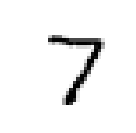

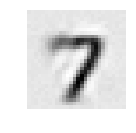

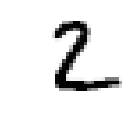

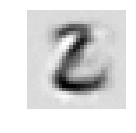

In [117]:
from matplotlib import pyplot as plt

def plot_image(image, shape=[28,28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    plt.show()
    
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## Visualizing Features

비교사 학습인 오토인코더를 응용해서 데이터의 특징을 찾아낼 수 있습니다.

사진에서 고양이를 탐지하는 기술로 예를 들어보겠습니다. 고양이가 없는 사진을 학습하다가 고양이가 있는 사진이 나타나면,

오토인코더 안의 뉴런들이 이전에 없던 데이타의 특징으로 인해 고양이 사진에 대해 활발한 뉴런활동을 보여줄 것입니다.

이는 가장 위의 (디코더와 가장 가까운) 히든 레이어에서 가장 부각됩니다. 

가장자리 레이어일수록 데이터에서 상대적으로 알아보기 쉽고 큰 특징을 잡아내기 때문입니다.

방금전의 mnist를 학습한 오토인코더의 첫벗째 히든 레이어를 살펴보겠습니다.

이 레이어에서 처음 다섯개의 뉴런은 데이타로부터 어떤 특징을 잡아냈는지 살펴보겠습니다.

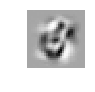

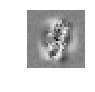

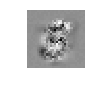

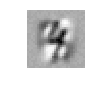

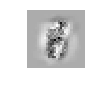

In [121]:
for i in range(5): 
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

또는 오토인코더에 임의의 입력 이미지를 제공하고 관심있는 뉴런의 활성화를 관찰 후 

역전파를 수행하여 뉴런이 더 많이 활성화되는 방식으로 이미지를 조정하는 것입니다. 

이 과정을 반복하면 이미지가 점차적으로 가장 뉴런에게 흥미로운 이미지로 바뀝니다. 

이것은 뉴런이 찾고있는 특징의 입력을 시각화하는 유용한 기술입니다.

## Unsupervised Pretraining Using Stacked Autoencoders

신경망 알고리즘에서 과제 수행을 위한 데이터가 부족하다면 비슷한 과제를 수행하는 신경망 알고리즘을 찾고

그 신경망의 하위 계층을 재사용하는 방법이 있습니다. 예를 들어 아시아인 얼굴을 구분하는 신경망을 만들고자 할 때,

일단 이미 존재하는 사람의 얼굴을 학습한 분류기를 사용해 적은데이타로 '얼굴'에 대한 학습이 완료된 상태에서

아시아인을 학습할 수 있습니다.

같은 아이디어로, 오토인코더를 이용해서도 응용 가능합니다.

![](4.png)

###### 볼츠만 머신 이야기가 나옴.. 

## Denoising Autoencoders

데이타에 노이즈를 추가하고 최종 출력은 잡음 없는 데이타가 되도록 교육하는 방법도 있습니다.

이렇게하면 자동 코더가 입력을 출력에 쉽게 복사하지 못하고 데이터에서 패턴을 찾아내야합니다.

![](5.png)

텐서플로우로 구현하는 것은 간단합니다. (드롭아웃 예제)

```python
keep_prob = 0.7

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

is_training = tf.placeholder_with_default(False, shape=(), name='is_training')
X_drop = dropout(X, keep_prob, is_training=is_training)

[...]
hidden1 = activation(tf.matmul(X_noisy, weights1) + biases1)
[...]
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE 
[...]
with tf.Session() as sess:
    sess.run(training_op, feed_dict={X: X_batch, is_training: True})
    # 테스트 과정에서는 False
    [...]
```

## Sparse Autoencoders

Sparsity를 이용해 더 효과적으로 특징을 추출 할 수 있습니다.

비용 함수에 적절한 항을 추가함으로써, 오토인코더가 코딩 레이어 뉴런의 활성화 정도를 줄이도록 유도합니다.

결과적으로 작은 특징들의 조합으로 데이타를 표현하는 인코더가 만들어 지게 됩니다.

일반적으로 이로인해 코딩 레이어의 각 뉴런들이 유용한 특징들을 잘 찾아내게 됩니다.

###### "비용 함수에 적절한 항을 추가함으로써, 오토인코더가 코딩 레이어의 활성 뉴런 수를 줄이도록 유도합니다. "

위 문장을 실현하기 위해서 반복되는 트레이닝 과정에서 코딩 레이어의 각 뉴런이 얼마나 활성화 되는지 측정해야합니다. 

뉴런당 평균적으로 얼마나 활성화 되는지를 비용함수에 추가해 주고 활동량이 큰 뉴런에 패널티를 줍니다.

예를 들어 뉴런의 평균 활성화 횟수가 0.3이지만 타겟 Sparsity가 0.1이라면 페널티를 적용하게 됩니다.

![](6.png)

###### 으으...

## Variational Autoencoders

Variational 오토인코더는 가장 인기있는 오토인코더 종류중 하나이며, 지금까지 논의한 모든 오토인코딩과는 상당히 다릅니다.

확률론적 오토인코더이며, 트레이닝 이후에도 출력이 확률적으로 결정됩니다.

또한 Generative 오토인코더입니다. 트레이닝데이타에서 샘플링 한 것처럼 보이는 새로운 인스턴스를 생성 할 수 있습니다.

![](7.png)

##### 으으 ...